## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted ==1').user_id.nunique()/df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
control=df.query("group=='control'")

In [7]:
control[control['landing_page']=='new_page'].landing_page.count()

1928

In [8]:
treatment=df.query("group=='treatment'")

In [9]:
treatment[treatment['landing_page']=='old_page'].landing_page.count()

1965

f. Check for missing values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


This dataset has no missing value. 

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.    



In [11]:
df2=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))]

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [14]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` 

a. Check how many unique **user_id**s are in **df2**

In [15]:
df2['user_id'].nunique()

290584

b. Check for duplicated **user_id** in **df2**.  

In [16]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. The row information for the repeat **user_id**? 

In [17]:
df2.iloc[2893]

user_id                             673693
timestamp       2017-01-22 07:32:26.184894
group                            treatment
landing_page                      new_page
converted                                0
Name: 2924, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [18]:
df2=df2.drop(2893)

`4.` 

a. The probability of an individual converting regardless of the page they receive

In [19]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, the probability they converted

In [20]:
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, the probability they converted

In [21]:
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

In [22]:
obs_diff=df2.query("group == 'treatment'")['converted'].mean()-df2.query("group == 'control'")['converted'].mean()
obs_diff

-0.0015782389853555567

d. The probability that an individual received the new page

In [23]:
df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

Conclusion: there is no sufficient evidence to conclude that new treatment page leads to more conversions. In contrast, based on the initial calculation, the new page led to a lower conversion rate compared to the old page, however in a very subtle amount. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, below are the null and alternative hypotheses

H0: P𝑜𝑙𝑑 >= P𝑛𝑒𝑤 

H1: P𝑜𝑙𝑑 < P𝑛𝑒𝑤 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

a.  **conversion rate** for $p_{new}$ under the null

In [24]:
P_null = df2['converted'].mean()
P_null

0.11959708724499628

b.  **conversion rate** for $p_{old}$ under the null <br><br>

In [25]:
P_null

0.11959708724499628

c. $n_{new}$, the number of individuals in the treatment group

In [26]:
n_new=df2.query("group == 'treatment'").shape[0]
n_new

145310

d.  $n_{old}$, the number of individuals in the control group

In [27]:
n_old= df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  

In [28]:
new_page_converted = np.random.binomial(1, P_null, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  

In [29]:
old_page_converted = np.random.binomial(1, P_null, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
diffs=new_page_converted.mean() - old_page_converted.mean()
diffs

-0.0012000959779517179

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used in parts (a) through (g) above. 

In [31]:
p_diffs = []

for _ in range (10000):
    sample=df2.sample(df2.shape[0], replace=True)
    old_page_converted1 = np.random.binomial(1, P_null, n_old).mean()
    new_page_converted1 = np.random.binomial(1, P_null, n_new).mean()
    p_diffs.append(new_page_converted1-old_page_converted1)

In [32]:
p_diffs=np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  

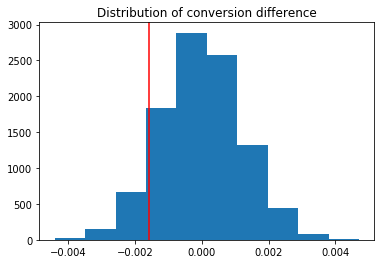

In [33]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r')
plt.title('Distribution of conversion difference');

j. The proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
(p_diffs>obs_diff).mean()

0.9022

k. Comments: In part j, we calculated the p-value, which is the probability of observing our statistics or a more extreme statistics if the null is true. In this case, the p-value indicates the difference is not statistically significant, and we fail to reject the null hyothesis that indicates that the old page brings a better or equal conversion rate compared to the new page. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2.query("group=='control' and converted ==1").shape[0]
convert_new = df2.query("group=='treatment' and converted ==1").shape[0]
n_old = df2.query("group=='control'").shape[0]
n_new = df2.query("group=='treatment'").shape[0]

convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute the test statistic and p-value.  

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. Comments: The z-score gives you an idea of how far from the mean a data point it. Here, it means that the difference between the test statistic and the null hypothesis is 1.31. which is smaller than 1.96, which is the cretical value for 95% confidence interval, so z-score implies we fail to reject the null. The p-value is 0.905 which matches our previus calculation, again indicates that we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 


a. We will be performing a logistic regression!

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. 

In [37]:
df2['intercept'] = 1
df2[['noab_page', 'ab_page']] = pd.get_dummies(df2['group'])


c. Use **statsmodels** to instantiate the regression model on the two columns we created in part b., then fit the model using the two columns we created in part **b.** to predict whether or not an individual converts. 

In [38]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of the model below

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:46:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. Comments: The p-value associated with ab_page is 0.190 from the logistic model. The null hypothesis associated with the reggression model is that the coefficient of the variable ab_page equals zero, meaning the different pages has no impact on conversion rate, and this null hypothesis is different from the null hypothesis we used in part II.

f. Comments: Based on the current regression result, the coefficient for the variable ab_page is not statistically significant, so it would be a good idea to consider other factors to add into the regression model. However, there could have disadvantages to adding additional terms into the model, such as multi-collinearity. We need to make sure the factors we are going to introduce into the model are not correlated with other factors in the model. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

In [40]:
country = pd.read_csv('countries.csv')
country.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [41]:
country.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [42]:
df2=df2.set_index('user_id').join(country.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,intercept,noab_page,ab_page,country
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [43]:
df2[['CA','UK','US']]=pd.get_dummies(df2['country'])

In [44]:
log2_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = log2_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        15:46:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

h. Create additional columns, and fit the new model.  



In [45]:
df2['CA_abpage'] =df2['ab_page']*df2['CA']
df2['UK_abpage'] =df2['ab_page']*df2['UK']

log3_mod = sm.Logit(df2['converted'], df2[['intercept', 'CA_abpage', 'UK_abpage']])
results = log3_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:               2.364e-05
Time:                        15:46:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
CA_abpage     -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_abpage      0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

In [46]:
np.exp(results.params)

intercept    0.135840
CA_abpage    0.927579
UK_abpage    1.015000
dtype: float64

In [47]:
1/0.927579

1.0780752906221465

Based on the result, only the coefficient for CA_abpage is statistically significant. Holding all other variables constant, a user from Canada and receives a new page is 1.078 times more likely to convert. This number doesn't provide much pratical significance, unfortunally. The coefficients for other variables are not statistically significant, meaning they have no impact on the user coversion rate. 

To sum up, we do not have enough evidence to reject the null hypothesis, and therefore, the company should keep the old page. 